<a href="https://colab.research.google.com/github/germanjke/Deep_Learning_School_MIPT/blob/master/NLP_seminars/language_models_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk gdown seaborn torchtext pymorphy2 gensim

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 8.2MB 6.8MB/s 


In [3]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Семинар: Language Model

Привет! Сегодня мы создадим свою Language Model! Посмотрим на три вида моделей: N-gram, CNN, LSTM. Для обучения LM лучше всего подходят большие корпуса с разнообразными текстами: от новостей до художственной литературы. Для русского языка есть большой корпус [Taiga](https://tatianashavrina.github.io/taiga_site/). Для английского используют тексты из [википедии](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) или [BookCorpus](https://github.com/soskek/bookcorpus). 

Сегодня вы возьмем маленькую часть датасета Taiga: новости с сайта [nplus1](https://nplus1.ru). Каждая новость на сайте помечается меткой сложности (от 0 до 10). Это не поможет нам с обучением хорошей LM, но даст возможность поиграться с генерацией текста.

Загрузим датасет и подготовим его к работе!

In [5]:
import gdown

url = 'https://drive.google.com/uc?id=1UtF9urwAL2OiMg7N5iFmZmeiRzq1Psw6'
output = 'nplus1.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UtF9urwAL2OiMg7N5iFmZmeiRzq1Psw6
To: /content/nplus1.zip
49.8MB [00:00, 74.6MB/s]


'nplus1.zip'

In [6]:
!unzip nplus1.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: __MACOSX/nplus1/texts_tagged/._20150921homo-3d-naledi.txt  
  inflating: nplus1/texts_tagged/20151029oxygen.txt  
  inflating: __MACOSX/nplus1/texts_tagged/._20151029oxygen.txt  
  inflating: nplus1/texts_tagged/20160901mriya2.txt  
  inflating: __MACOSX/nplus1/texts_tagged/._20160901mriya2.txt  
  inflating: nplus1/texts_tagged/20150709entropy-nano.txt  
  inflating: __MACOSX/nplus1/texts_tagged/._20150709entropy-nano.txt  
  inflating: nplus1/texts_tagged/20160526Corded-ware-culture-women.txt  
  inflating: __MACOSX/nplus1/texts_tagged/._20160526Corded-ware-culture-women.txt  
  inflating: nplus1/texts_tagged/20160603chopper.txt  
  inflating: __MACOSX/nplus1/texts_tagged/._20160603chopper.txt  
  inflating: nplus1/texts_tagged/20151026stemi.txt  
  inflating: __MACOSX/nplus1/texts_tagged/._20151026stemi.txt  
  inflating: nplus1/texts_tagged/20160326cygnus.txt  
  inflating: __MACOSX/nplus1/texts_tagged

In [7]:
!ls nplus1/

newmetadata.csv  texts	texts_tagged


Вся информация про тексты содержится в таблице `newmetadata.csv`. Загрузим её с помощью `pandas`.

In [8]:
import pandas as pd


metadata = pd.read_table("nplus1/newmetadata.csv")
metadata.head()

,segment,textid,textname,textregion,textrubric,textdiff,author,authortexts,authorreaders,magazine,date,time,tags,source
0,nplus1,20151029radar,Французы испытали пассивный «летающий радар»,NaN,Оружие,2.1,Василий Сычев,NaN,NaN,NaN,29 Окт. 2015,16:47,NaN,https://nplus1.ru/news/2015/10/29/radar
1,nplus1,20161212aggressive-drones,Для агрессивных маневров дронам хватило камеры...,NaN,Технологии,2.6,Николай Воронцов,NaN,NaN,NaN,12 Дек. 2016,17:27,NaN,https://nplus1.ru/news/2016/12/12/aggressive-d...
2,nplus1,20150826twinjet-hubble,«Хаббл» получил новые фотографии «крыльев» Баб...,NaN,Технологии,1.1,NaN,NaN,NaN,NaN,26 Авг. 2015,17:46,NaN,https://nplus1.ru/news/2015/08/26/twinjet-hubble
3,nplus1,20150826shining-solved-profile,Криминологи научились вычислять будущих бытовы...,NaN,NaN,4.4,NaN,NaN,NaN,NaN,26 Авг. 2015,14:15,NaN,https://nplus1.ru/news/2015/08/26/shining-solv...
4,nplus1,20160111snow,Ford начал снежные испытания беспилотного авто...,NaN,Транспорт,1.7,Василий Сычев,NaN,NaN,NaN,11 Янв. 2016,09:44,NaN,https://nplus1.ru/news/2016/01/11/snow


Колонка `textdiff` содержит информацию про сложность текста. Чтобы выделить нужный кусок, воспользуемся методами `pandas`.

In [10]:
metadata[(metadata["textdiff"] > 4) & (metadata["textdiff"] < 5)].shape

(793, 14)

Посмотрим на распределение сложности текстов:

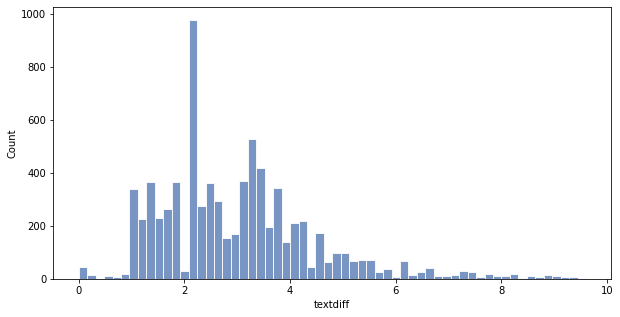

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


_, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.set()
sns.histplot(metadata["textdiff"], ax=ax)

Загрузим предобученные эмбеддинги, которые готовы к работе с русским языком ([весь список](https://rusvectores.org/ru/models/)). Из-за особенностей русского языка эмбеддинги ожидают строку вида `{слово}_{часть речи}`. Надо про это помнить при работе с этими эмбеддингами.

In [12]:
from gensim import downloader as api

word2vec = api.load('word2vec-ruscorpora-300')

[================================================--] 97.7% 194.2/198.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Подготовим датасет к работе с моделями:

In [13]:
from pathlib import Path
import string

import numpy as np
from tqdm.notebook import tqdm

import nltk
from pymorphy2 import MorphAnalyzer

from torch.utils.data import Dataset, random_split


PAD = "<PAD>"
EOS = "<EOS>"
UNK = "<UNK>"


class TextDataset(Dataset):
    def __init__(self, min_diff=0, max_diff=10):
        self.root = Path("nplus1/texts")
        metadata = pd.read_table("nplus1/newmetadata.csv")
        self.metadata = metadata[(metadata["textdiff"] > min_diff) & (metadata["textdiff"] <= max_diff)]
        
        # Получим список всех текстов и сверим его с таблицей
        file_paths = np.array(list(self.root.glob("*.txt")))
        text_ids = np.array(list(path.name.split(".")[0] for path in file_paths))
        self.text_ids = text_ids[np.isin(text_ids, self.metadata["textid"])]
        self.file_paths = file_paths[np.isin(text_ids, self.metadata["textid"])]
        
        self.min_diff = min_diff
        self.max_diff = max_diff
        
        self.tokenizer = nltk.WordPunctTokenizer()
        self.morph = MorphAnalyzer()
        
        self.token2idx = {PAD: 0, EOS: 1, UNK: 2}
        self.vocab = set([PAD, EOS, UNK])
        for path in tqdm(self.file_paths):
            with open(path) as file:
                text = file.read()
                self.vocab.update([token for token in self.tokenize_(text) if token not in (UNK, PAD, EOS)]) # добавь токены в словарь
        self.token2idx.update({t:num + 3 for num, t in enumerate(self.vocab) if t not in (UNK, PAD, EOS)})
        self.idx2token = {num: token for token, num in self.token2idx.items()}
            
    
    def __getitem__(self, item):
        with open(self.file_paths[item]) as file:
            text = file.read()
            
        tokens = self.tokenize_(text)
        
        text_id = self.text_ids[item]
        textdiff = self.metadata[self.metadata["textid"] == text_id]["textdiff"]
        
        # для обучение нейронок нам потребуются индексы токенов в словаре.
        input_ids = [self.token2idx[token] for token in tokens]
        
        return {
            "text": text,
            "tokens": tokens,
            "textdiff": textdiff,
            "input_ids": input_ids
        }
    
    def __len__(self):
        return len(self.file_paths)
    
    def tokenize_(self, text):
        tokens = self.tokenizer.tokenize(text.lower())
        morphs = [self.morph.parse(token)[0]
                  for token in tokens 
                  if (token not in string.punctuation)]
        tokens = [f"{morph.normal_form}_{morph.tag.POS}" for morph in morphs]
        tokens = [token for token in tokens if token in word2vec]
        tokens += [EOS]
        return tokens
    
    def embeddins(self):
        w = torch.rand(len(self.vocab) + 1, word2vec.vector_size)
        for token, num in self.token2idx.items():
            if token in word2vec:
                w[num] = torch.from_numpy(word2vec[token])
        return w

In [14]:
dataset = TextDataset(0.5, 2)
train_size = np.ceil(len(dataset) * 0.8).astype(int)


train_dataset, valid_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

## 1. N-gram LM

Первая жертва – N-граммная модель. Она пишется скучно, но хорошо работает.

In [15]:
from collections import Counter, defaultdict

from tqdm.notebook import tqdm


class NGramModel(object):
    '''
    Структура этой реализации n-граммной модели следующая:
    self.ngrams – словарь, который на каждый (token_0, ..., token_(n-1)) – n-1 tuple из токенов
        хранит частоту появления следующего токена. Для подсчета числа токенов воспользуемся
        Counter
    self.tokenize_func – функция токенизации текста. С её помощью будем получать токены.
    '''
    def __init__(self, n=2):
        self.ngrams = defaultdict(Counter)
        self.n = n
        self.tokenize_func = None
        
    def compute_ngrams(self, dataset, tokenize_func):
        self.tokenize_func = tokenize_func
        self.ngrams = defaultdict(Counter)
        for row in tqdm(dataset):
            ngram = [PAD] * self.n
            for token in row["tokens"]:
                ngram[:-1] = ngram[1:]
                ngram[-1] = token
                self.ngrams[tuple(ngram[:-1])].update([ngram[-1]])
            
    def get_log_probs(self, prefix, min_log_pr=-15):
        '''
        Функция, которая будет возвращать логарифмы частот появления токенов
        '''
        if isinstance(prefix, str):
            # преврати строку в tuple из токенов с помощью tokenize_func. 
            prefix = self.tokenize_func(prefix)[:-1]
        if len(prefix) < self.n - 1:
            prefix = [PAD] * (self.n - len(prefix) - 1) + prefix
        else:
            prefix = prefix[-self.n + 1:]
        possible_ends = self.ngrams[tuple(prefix)]
        sum_freq = np.log(sum(possible_ends[e] for e in possible_ends))
        return {e: np.log(possible_ends[e]) - sum_freq for e in possible_ends}
    
    def sample(self, prefix):
        possible_ends = self.get_log_probs(prefix)
        if len(possible_ends) > 0:
            end = np.random.choice(list(possible_ends.keys()), p=np.exp(list(possible_ends.values())))
            return end
        return EOS

Создадим 5-граммную модель и посмотрим, как хорошо справляется она с генерацией текста.

In [16]:
frigram = NGramModel(5)

In [17]:
frigram.compute_ngrams(train_dataset, dataset.tokenize_)

In [18]:
frigram.get_log_probs("")

{'авиакомпания_NOUN': -7.29776828253138,
 'авиасалон_NOUN': -7.29776828253138,
 'австралиец_NOUN': -7.29776828253138,
 'австралия_NOUN': -7.29776828253138,
 'автомобиль_NOUN': -5.68833037009728,
 'автопроизводитель_NOUN': -5.506008813303325,
 'агенство_NOUN': -7.29776828253138,
 'агентство_NOUN': -4.302036008977389,
 'администрация_NOUN': -7.29776828253138,
 'академия_NOUN': -6.604621101971435,
 'активность_NOUN': -7.29776828253138,
 'аллен_NOUN': -7.29776828253138,
 'альпинист_NOUN': -7.29776828253138,
 'американец_NOUN': -5.351858133476067,
 'американка_NOUN': -7.29776828253138,
 'англичанин_NOUN': -7.29776828253138,
 'анимация_NOUN': -7.29776828253138,
 'аппарат_NOUN': -4.35332930336494,
 'армения_NOUN': -7.29776828253138,
 'армия_NOUN': -7.29776828253138,
 'арсенал_NOUN': -6.604621101971435,
 'археолог_NOUN': -3.385745277103234,
 'архитектор_NOUN': -7.29776828253138,
 'аспирант_NOUN': -7.29776828253138,
 'астроном_NOUN': -7.29776828253138,
 'атака_NOUN': -7.29776828253138,
 'банк_N

In [22]:
frigram.sample("университет")

'джорджия_NOUN'

In [23]:
def generate_text(model, prefix, length=100):
    text = "" + prefix
    while len(text) < length:
        token = model.sample(text)
        text += " " + token
        if token < EOS:
            break
    return text

In [24]:
generate_text(frigram, "")

' компания_NOUN компания_NOUN автомобиль_NOUN храм_NOUN специалист_NOUN старт_NOUN группа_NOUN электромобиль_NOUN'

Количественная величина, которая позволяет сравнивать LM: перплекция. Для её вычисления используется следующая формула:

$$
\text{Ppr} = \exp^{\frac{1}{|D|} \sum_{t \in D}\sum_{w \in t} - \log (p(w))},
$$
где $D$ – валидационный датасет, $|D|$ – общая длина текстов.

In [25]:
def perplexity_ngram(dataset, model):
    lengths = 0
    log_prob = 0
    for row in tqdm(dataset):
        tokens = row["tokens"]
        lengths += len(tokens)
        ngram = [PAD] * model.n
        for token in tokens:
            ngram[:-1] = ngram[1:]
            ngram[-1] = token
            log_prob += model.get_log_probs(ngram[:-1]).get(ngram[-1], -15)
    return np.exp(-log_prob / lengths)

In [26]:
perplexity_ngram(valid_dataset, frigram)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


1499837.142047057

## 2. NN LM

Приступим к нейросетевым языковым моделям. Для начала нам потребуется сэмплер из прошлого семинара.

In [27]:
from torch.utils.data import Sampler


class TextSampler(Sampler):
    def __init__(self, sampler, batch_size_tokens=1e4):
        self.sampler = sampler
        self.batch_size_tokens = batch_size_tokens

    def __iter__(self):
        batch = []
        max_len = 0
        for ix in self.sampler:
            row = self.sampler.data_source[ix]
            max_len = max(max_len, len(row["input_ids"]))
            if (len(batch) + 1) * max_len > self.batch_size_tokens:
                yield batch
                batch = []
                max_len = len(row["input_ids"])
            batch.append(ix)
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return len(self.sampler)

In [28]:
def collate_fn(batch):
    max_len = max(len(row["input_ids"]) for row in batch)
    input_embeds = np.zeros((len(batch), max_len))
    for idx, row in enumerate(batch):
        input_embeds[idx][:len(row["input_ids"])] += row["input_ids"]
    row["input_ids"] = torch.LongTensor(input_embeds)
    return row

In [29]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, random_split


train_sampler = RandomSampler(train_dataset)
valid_sampler = SequentialSampler(valid_dataset)

train_loader = DataLoader(train_dataset, batch_sampler=TextSampler(train_sampler), collate_fn=collate_fn, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_sampler=TextSampler(valid_sampler), collate_fn=collate_fn, num_workers=4)

### CNN

Вторая жертва – CNN. Если внимательно посмотреть, то она является нейросетевым приближением к n-грамной модели. Для её реализации нам потребуется новым модуль – `nn.ZeroPad2d`[docs](https://pytorch.org/docs/stable/generated/torch.nn.ZeroPad2d.html). Он добавит нулей в нужном месте, чтобы конволюционный слой смотрел только на предыдущие токены при предсказании текущего.

In [30]:
import torch
import torch.nn as nn


class CNNLM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pad = nn.ZeroPad2d((4, 0, 0, 0))
        self.conv = nn.Conv1d(emb_size, hidden_size, kernel_size=5)
        self.pred = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_ids):
        embed = self.emb(input_ids).permute(0, 2, 1)
        padded = self.pad(embed)
        convolved = torch.relu(self.conv(padded)).permute(0, 2, 1)
        return self.pred(convolved)

In [31]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

model = CNNLM(len(dataset.vocab) + 4, 300, 100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.token2idx[PAD])

In [32]:
def embeddings(self):
    w = torch.rand(len(self.vocab) + 4, word2vec.vector_size)
    for token, num in self.token2idx.items():
        if token in word2vec:
            w[num] = torch.from_numpy(word2vec[token])
    return w

In [33]:
with torch.no_grad():
    model.emb.weight.copy_(embeddings(dataset))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  """


In [34]:
num_epochs = 1

for e in range(num_epochs):
    model.train()
    with tqdm(total=len(train_loader)) as pbar:
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)

            prediction = model(input_ids[:, :-1])
            loss = criterion(
                prediction.reshape(-1, prediction.size(-1)), 
                input_ids[:, 1:].reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            # обучи модель 

            pbar.update(input_ids.size(0))
        
    model.eval()
    valid_loss = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_loader:
            n_iter += 1
            input_ids = batch["input_ids"].to(device)
            prediction = model(input_ids[:, :-1])
            valid_loss += criterion(prediction.reshape(-1, prediction.size(-1)), input_ids[:, 1:].reshape(-1))
    print(f"Valid Loss: {valid_loss / n_iter}, Valid Peprplexity: {torch.exp(valid_loss / n_iter)}")


Valid Loss: 7.5562310218811035, Valid Peprplexity: 1912.623291015625


После обучения модели посмотрим, как она справляется с задачей генерации текста. Сделаем специальную функцию для этого.

In [35]:
def sample(model, prefix, max_length=100):
    tokens = dataset.tokenize_(prefix)[:-1]
    input_ids = [dataset.token2idx.get(token) for token in tokens]
    input_ids_tensor = torch.LongTensor(input_ids).unsqueeze(0).to(device)
    
    with torch.no_grad():
        while True:
            output = model(input_ids_tensor)

            probs = torch.softmax(output[:, -1].cpu(), -1).numpy()[0]
            # получи из output вероятности следующего токена
            next_id = np.random.choice(np.arange(len(dataset.vocab) + 4), p=probs)
            # получи следующий токен
            tokens += [dataset.idx2token[next_id]]
            # добавь токен в список токенов
            
            if dataset.idx2token[next_id] == EOS or len(tokens) > max_length:
                break
            input_ids += [next_id]
            input_ids_tensor = torch.LongTensor(input_ids).unsqueeze(0).to(device)
    
    return " ".join(t.split("_")[0] for t in tokens)

In [36]:
model.eval()
sample(model, "университет")

'университет ловить мгу олег <EOS>'

### LSTM

Последняя жертва – LSTM. Она должна лучше работать с длинными текстами, потому что у неё нет фиксированного количества токенов, на которые она можеть "смотреть".

In [37]:
import torch
import torch.nn as nn


class LSTMLM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        # Сделай lstm слой
        self.pred = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_ids):
        embs = self.emb(input_ids)
        output, _ = self.lstm(embs)
        return self.pred(output)

In [38]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

model = LSTMLM(len(dataset.vocab) + 4, 300, 100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.token2idx[PAD])

In [39]:
with torch.no_grad():
    model.emb.weight.copy_(embeddings(dataset))

In [40]:
num_epochs = 1

for e in range(num_epochs):
    model.train()
    with tqdm(total=len(train_loader)) as pbar:
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)

            prediction = model(input_ids[:, :-1])
            loss = criterion(
                prediction.reshape(-1, prediction.size(-1)), 
                input_ids[:, 1:].reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            # обучи модель 

            pbar.update(input_ids.size(0))
        
    model.eval()
    valid_loss = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_loader:
            n_iter += 1
            input_ids = batch["input_ids"].to(device)
            prediction = model(input_ids[:, :-1])
            valid_loss += criterion(prediction.reshape(-1, prediction.size(-1)), input_ids[:, 1:].reshape(-1))
    print(f"Valid Loss: {valid_loss / n_iter}, Valid Peprplexity: {torch.exp(valid_loss / n_iter)}")


Valid Loss: 7.64757776260376, Valid Peprplexity: 2095.5634765625


In [41]:
model.eval()
sample(model, "университет")

'университет гималаи сотрудник плеврит иерихон патрис оборона заниматься поколение василий воронцов условие страна лопасть афон продукт местонахождение алюминий университет модуль скорость ловушка беспилотник приобретение рулетка фрустрация миллион <EOS>'

### Что дальше?
 
Если мы говорим про генерацию, то модель надо обучать подольше и на большом количестве текста. Если хочешь поэкспериментировать с генерацией, то я предлагаю такой план:
 
- обучи модель на всех новостях (min_diff=0, max_diff=10)
- сохрани веса этой модели (torch.save(model.state_dict()))
- переобучи несколько моделей на новостях с другими значениями сложности (eg. (min_diff=1, max_diff=3), (min_diff=4, max_diff=8))
- сравни сгенерированные тексты

charLM
CNN(char) -> LSTM
BPE